# Dr Dennett's Guide to Spatial Interaction Modelling  -  Part 2: Constrained Models 
Code translated to Python by Philip Wilkinson
## Recap

So, last time we learned all about the unconstrained spatial interaction model; how we can use it to estimate flows in a system using values for origin emissiveness or destination attractiveness; how we can tweak the estimates the model produces through adjusting either the parameters associated with the predictor variables, or through using different predictor variables or updating their values; and how we can improve the fits of the model further by calibrating the paramaters through using a Poisson regression model.

We saw that even after calibration, our model still only explained around 60% of the variation in the flows that we observed in our system, so can we do any better? Well yes, yes we can!

First of all however, lets bring some of our work across from the previous practical so that we can get straight to it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
cdatasub = pd.read_csv("Data/cdatasub1.csv", index_col=0)

# Constrained models

If we return to [Alan Wilson's 1971 paper](https://journals.sagepub.com/doi/abs/10.1068/a030001), he introduces a full <i>family</i> of spatial interaction models of which the unconstrained model is just the start. And indeed since then, there have been all number of incremental advances and alternatives (such as [Stewart Fotheringham's Competing Destinations models](https://www.researchgate.net/publication/23537117_A_New_Set_of_Spatial-Interaction_Models_The_Theory_of_Competing_Destinations), [Pooler's production/attractino/cost relaxed models](http://journals.sagepub.com/doi/abs/10.1177/030913259401800102), [Stillwell's origin/destination parameter specific models](http://journals.sagepub.com/doi/pdf/10.1068/a101187) and [mine and Alan's own multi-level model](http://journals.sagepub.com/doi/pdf/10.1068/a45398) (to name just a few).

In this session we will explore the rest of Wilson's family - the Production (origin) Constrained Model; the Attraction (destination) Constrained Model; and the Doubly Constrained Model.

We will see how we can, again, use a Poisson regression model in Python to calibrate these models and how, once calibrated, we can use the models in different contexts, such as Land Use Transportation Interaction (LUTI) modelling, retail modelling and migration modelling.

# 1. Production and Attraction Constrained Models

First of all let us extract the results that we got last time:

In [4]:
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


Wilson's real contribution to the field was in noticing that the unconstrained gravity model was sub-optimal as it did not make use of all of the available data in the system we are studying.

If we recall the estimates from our unconstrained model, none of the estimates summed to the observed in and out-flow totals:

In [5]:
cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,206.0,808.0,145.0,294.0,308.0,1264.0,3025
Barnet,1015.0,NaN,968.0,5683.0,919.0,6422.0,9587.0,24594
Bexley,2231.0,542.0,NaN,430.0,2099.0,869.0,3803.0,9974
Brent,591.0,4707.0,636.0,NaN,686.0,4957.0,7034.0,18611
Bromley,1480.0,937.0,3820.0,844.0,NaN,1567.0,6670.0,15318
Camden,623.0,2635.0,637.0,2455.0,630.0,NaN,15056.0,22036
City of London,20.0,32.0,22.0,28.0,22.0,121.0,NaN,245
All,5960.0,9059.0,6891.0,9585.0,4650.0,14244.0,43414.0,93803


Our estimates did sum to the grand total of flows, but this is because we were really fitting a 'total constrained' model which used $k$ - our constant of proportionality -  to ensure everything sort of added up (to within 1 commuter).

Where we have a full flow matrix to calibrate parameters, we can incorporate the row (origin) totals, column (destination) totals or both origin and destination totals to <i>constrain</i> our flow estimates to these known values.

There are various reasons for wanting to do this, for example:

1. If we are interested in flows of money into businesses or customers into shops, we might have information on the amount of disposable income and shopping habits of the people living in different areas from loyalty card data. This is known information about our origins and so we could constrain our spatial interaction model to this known information - we can make the assumption that this level of disposable income remains the same. We can then use other information about the attractiveness of places these people might like to shop in (store size, variety / specialism of goods etc.), to estimate how much money a new store opening in the area might make, or if a new out-of-town shopping centre opens, how much it might affect the business of shops in the town centre. This is what is known in the literature as the ‘retail model’ and is perhaps the most common example of a <b>Production (orign) Constrained Spatial Interaction Model</b>.

2. We might be interested in understanding the impact of a large new employer in an area on the flows of traffic in the vicinity or on the demand for new worker accommodation nearby. A good example of where this might be the case is with large new infrastructure developments like new airports. For example, before the go-ahead for the new third runway at Heathrow was given, one option being considered was a new runway in the Thames Estuary. If a new airport was built here, what would be the potential impact on transport flows in the area and where might workers commute from? This sort of scenario could be tested with an <b>Attraction (destination) Constrained Spatial Interaction Model</b> where the number of new jobs in a destination is known (as well as jobs in the surrounding area) and the model could be used to estimate where the workers will be drawn from (and their likely travel-to-work patterns). 

3. We might be interested in understanding the changing patterns of commuting or migration over time. Data from the Census allows us to know an accurate snap-shot of migrating and commuting patterns every 10 years. In these full data matrices, we know both the numbers of commuters/migrants leaving origins and arriving at destinations as well as the interactions between them. If we constrain our model estimates to this known information at origin and destination, we can examine various things, including:
    - The ways that the patterns of commuting/migration differ from the model predictions - where we might get more migrant/commuter flows than we would expect.
    - How the model parameters vary over time - for example how does distance / cost of travel affect flows over time? Are people prepared to travel further or less far than before?

# 2. Production-constrained Model


\begin{equation} \label{eq:1} \tag{1}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \label{eq:2} \tag{2}
O_i = \sum_j T_{ij}
\end{equation}

and

\begin{equation} \label{eq:3} \tag{3}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

In the production-constrained model, $O_i$ does not have a parameter as it is a known constraint. $A_i$ is known as a <i>balancing factor</i> and is a vector of values which relate to each origin, $i$, which do the equivalent job to $k$ in the unconstrained/total constrained model but ensure that flow estimates from each origin sum to the known totals, $O_i$ rather than just the overall total.

Now at this point, we could calculate all of the $O_i$s and $A_i$s by hand for our sample system and then set about guessing/estimating the parameter values for the rest of the model, but as you might have already suspected from last time, we can use Python and `glm` to make it really easy and do all of that for us -woo hoo!

We set about re-specifying the Production Constrained model as a Poisson regression model in exactly the same way as we did before. We need to take logs of the right-hand side of the equation and assume that these are logarithmically linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. As such, Equation (1) becomes:

\begin{equation} \label{eq:4} \tag{4}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In Equation (4) $\alpha_i$ is the equivalent of the vector of balancing factors $A_i$, but in regression /log-linear modelling terminology can also be described as either <b>dummy variables</b> or <b>fixed effects</b>. In practical terms, what this means is that in our regression model, $\alpha_i$ is modelled as a [categorical predictor](https://en.wikipedia.org/wiki/Categorical_variable) and therefore in the Poisson regression model, we don't use the numeric values of $O_i$, we can use a categorical identifier for the origin. In terms of the example table above, for Barking and Dagenham we wouldn't use 5675 as we would if we were fitting Equation (1), we would just used 'Barking and Dagenham'.

So, let's give this model a whirl...

In [6]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'Total ~ OrigCodeNew + log_Dj2_destsal + log_Dist-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14977.
Date:                Fri, 27 Jan 2023   Deviance:                       29640.
Time:                        10:45:53   Pearson chi2:                 2.89e+04
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
OrigCodeNew[E09000001]     4

So, what do we have?

Well, there are the elements of the model output that should be familiar from the unconstrained model:

The $\gamma$ parameter related to the destination attractiveness: 2.0440

The $\beta$ distance decay parameter: 2.2140. Recall the negative sign in the equation.

We can see from the standard outputs from the model that all of the explanatory variables are statistically significant (P>|z| < 0.01) and the z-scores indicate that the destination salary is having the most influence on the model, with distance following closely behind. And then we have a series of paramaters which are the vector of $\alpha_i$ values associated with our origin constraints.

## 2.1 Model Estimates

Now at this point you will be wanting to know what effect the constraints have had on the estimates produced by the model, so let's plug the parameters back into Equation 4 and take a look...

Create some $O_i$ and $D_j$ columns and store the total in and out flow matrix margins in them. 

In [7]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Total"].agg(np.sum))
O_i.rename(columns={"Total":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "OrigCodeNew", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["DestCodeNew"])["Total"].agg(np.sum))
D_j.rename(columns={"Total":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "DestCodeNew", how = "left" )

Now we want to fish the coefficients out of the prodSim glm object.

In [8]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(OrigCodeNew)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="OrigCodeNew", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()


/tmp/ipykernel_248/410688802.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,Dist,unconstrainedEst1,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,15995.228542,121,9.392662,9.692767,9.680046,20,20.489486,371,674,4.489223
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,13935.670950,184,9.392662,9.836279,9.542207,32,31.512083,371,8122,4.489223
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,17359.908682,116,9.392662,9.814656,9.761919,22,22.318539,371,3389,4.489223
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,13119.797208,183,9.392662,9.711116,9.481878,28,27.914377,371,7356,4.489223
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,18740.822949,104,9.392662,9.857444,9.838459,22,21.501729,371,5266,4.489223


OK, now we can save our parameter values into some variables... 

In [9]:
alpha_i = prodSim.params[0:7]
gamma = prodSim.params[7]
beta = -prodSim.params[8]

In [10]:
alpha_i

OrigCodeNew[E09000001]    4.489223
OrigCodeNew[E09000002]    7.724716
OrigCodeNew[E09000003]    8.751321
OrigCodeNew[E09000004]    8.709541
OrigCodeNew[E09000005]    8.248203
OrigCodeNew[E09000006]    9.254456
OrigCodeNew[E09000007]    6.769062
dtype: float64

In [11]:
gamma

2.0439647058311694

And we're ready to generate our estimates:

\begin{equation} \label{eq:4} \tag{4}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In [12]:
cdatasub["prodsimest1"] = np.exp(cdatasub["alpha_i"]+gamma*cdatasub["log_Dj2_destsal"] 
                                 - beta*cdatasub["log_Dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdatasub.head(10)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,unconstrainedEst1,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i,prodsimest1
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,121,9.392662,9.692767,9.680046,20,20.489486,371,674,4.489223,17.631667
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,184,9.392662,9.836279,9.542207,32,31.512083,371,8122,4.489223,32.078927
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,116,9.392662,9.814656,9.761919,22,22.318539,371,3389,4.489223,18.869970
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,183,9.392662,9.711116,9.481878,28,27.914377,371,7356,4.489223,28.387166
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,104,9.392662,9.857444,9.838459,22,21.501729,371,5266,4.489223,17.384337
5,E09000001,E09000007,335,City of London,00AA,Camden,00AG,335,0,104,...,1148,9.392662,9.893437,8.655705,121,120.620310,371,28270,4.489223,256.647934
6,E09000002,E09000001,3641,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,...,1335,10.933107,10.553205,9.680046,1264,1263.781820,5675,40725,7.724716,2601.636927
7,E09000002,E09000003,194,Barking and Dagenham,00AB,Barnet,00AC,194,0,29,...,265,10.933107,9.836279,10.130640,206,205.725662,5675,8122,7.724716,221.612141
8,E09000002,E09000004,96,Barking and Dagenham,00AB,Bexley,00AD,96,0,6,...,1902,10.933107,9.814656,9.133987,808,807.656203,5675,3389,7.724716,1926.150462
9,E09000002,E09000005,178,Barking and Dagenham,00AB,Brent,00AE,178,0,47,...,190,10.933107,9.711116,10.234810,145,144.562407,5675,7356,7.724716,136.247210


## 2.2 Assessing the model output

So what do the outputs from our Production Constrained Model look like? How has the goodness-of-fit improved and how can we start to use this a bit like a retail model and assess the likley impacts of changing detsination attractiveness etc.?

### 2.2.1 The flow matrics

In [13]:
#first round the estimates
cdatasub["prodsimest1"] = round(cdatasub["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
cdatasubmat3 = cdatasub.pivot_table(values ="prodsimest1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,222.0,1926.0,136.0,385.0,405.0,2602.0,5676.0
Barnet,461.0,NaN,401.0,6859.0,361.0,7525.0,9854.0,25461.0
Bexley,4020.0,402.0,NaN,299.0,3336.0,818.0,5811.0,14686.0
Brent,222.0,5357.0,233.0,NaN,256.0,5631.0,6810.0,18509.0
Bromley,1268.0,571.0,5271.0,519.0,NaN,1243.0,8458.0,17330.0
Camden,103.0,922.0,100.0,884.0,96.0,NaN,9663.0,11768.0
City of London,18.0,32.0,19.0,28.0,17.0,257.0,NaN,371.0
All,6092.0,7506.0,7950.0,8725.0,4451.0,15879.0,43198.0,93801.0


And compared with the original observed data?

In [14]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


Here it is very easy to see the Origin Constrained working. The sum across all destinations for each origin in the estimated matrix is exactly the same sum (give or take 1 or 2) across the observed matrics - $\sum_j T_{ij} = \sum_j \lambda_{ij} = O_i$, but clearly, the same is not true when you sum across all origins for each destination - $\sum_i T_{ij} \neq \sum_i \lambda_{ij} \neq D_j$

### 2.2.2 How do the fits compare with the unconstrained model from last time?

In [15]:
CalcRSquared(cdatasub["Total"], cdatasub["prodsimest1"])

0.8127672271674716

In [16]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest1"])

1400.714

Clearly by constraining our model estimates to known origin totals, the fit of the model has improved quite considerably - from around 0.67 in the unconstrained model to around 0.81 in this model. The RMSE has also dropped quite noticeably.

### 2.2.3 A 'what if...' scenario

Now that have have calibrated our parameters and produced some estimates, we can start to play around with some what-if scenarios.

For example, What if the government invested loads of money into a new Car Plant in Barking and Dagenham and as a result, average wages increased from £16,200 to £25,000. 

First create a new variable with these altered salaries.

In [17]:
def new_sal(row):
    if row["DestCodeNew"] == "E09000002":
        val = 25000
    else:
        val = row["Dj2_destsal"]
    return val
        
cdatasub["Dj3_destsalScenario"] = cdatasub.apply(new_sal, axis =1)
cdatasub.head(10)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i,prodsimest1,Dj3_destsalScenario
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,9.392662,9.692767,9.680046,20,20.489486,371,674,4.489223,18.0,25000
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,9.392662,9.836279,9.542207,32,31.512083,371,8122,4.489223,32.0,18700
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,9.392662,9.814656,9.761919,22,22.318539,371,3389,4.489223,19.0,18300
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,9.392662,9.711116,9.481878,28,27.914377,371,7356,4.489223,28.0,16500
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,9.392662,9.857444,9.838459,22,21.501729,371,5266,4.489223,17.0,19100
5,E09000001,E09000007,335,City of London,00AA,Camden,00AG,335,0,104,...,9.392662,9.893437,8.655705,121,120.620310,371,28270,4.489223,257.0,19800
6,E09000002,E09000001,3641,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,...,10.933107,10.553205,9.680046,1264,1263.781820,5675,40725,7.724716,2602.0,38300
7,E09000002,E09000003,194,Barking and Dagenham,00AB,Barnet,00AC,194,0,29,...,10.933107,9.836279,10.130640,206,205.725662,5675,8122,7.724716,222.0,18700
8,E09000002,E09000004,96,Barking and Dagenham,00AB,Bexley,00AD,96,0,6,...,10.933107,9.814656,9.133987,808,807.656203,5675,3389,7.724716,1926.0,18300
9,E09000002,E09000005,178,Barking and Dagenham,00AB,Brent,00AE,178,0,47,...,10.933107,9.711116,10.234810,145,144.562407,5675,7356,7.724716,136.0,16500


Now let's plug these new values into the model and see how this changes the flows in the system ...

In [18]:
cdatasub["prodsimest2"] = np.exp(cdatasub["alpha_i"]+gamma*np.log(cdatasub["Dj3_destsalScenario"]) - beta*cdatasub["log_Dist"])

cdatasub["prodsimest2"] = round(cdatasub["prodsimest2"],0)
#now we can convert the pivot table into a matrix
cdatasubmat4 = cdatasub.pivot_table(values ="prodsimest2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat4

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,222.0,1926.0,136.0,385.0,405.0,2602.0,5676.0
Barnet,1120.0,NaN,401.0,6859.0,361.0,7525.0,9854.0,26120.0
Bexley,9757.0,402.0,NaN,299.0,3336.0,818.0,5811.0,20423.0
Brent,538.0,5357.0,233.0,NaN,256.0,5631.0,6810.0,18825.0
Bromley,3078.0,571.0,5271.0,519.0,NaN,1243.0,8458.0,19140.0
Camden,251.0,922.0,100.0,884.0,96.0,NaN,9663.0,11916.0
City of London,43.0,32.0,19.0,28.0,17.0,257.0,NaN,396.0
All,14787.0,7506.0,7950.0,8725.0,4451.0,15879.0,43198.0,102496.0


You will notice that by increasing the average salary in Barking and Dagenham, we’ve increased flows into Barking and Dagenham, but have not reduced the flows into other zones - the original constraints are still working on the other zones. One way to get around this, now that we have calibrated our parameters, is to return to the multiplicative model in Equation 1 and run this model after calculating our own $A_i$ balancing factors.

In [19]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["Dj2_destsal"]**gamma
dist_beta = cdatasub["Dist"]**-beta
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCodeNew", right_index=True, how="left")

So that is it for calculating your $A_i$ values. Now you have these, it’s very simple to plug everything back into Equation 1 and generate some estimates…

In [20]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest3"] = cdatasub["A_i"]*cdatasub["O_i"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest3"] = round(cdatasub["prodsimest3"])
#check
cdatasub[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,18.0,18.0
1,32.0,32.0
2,19.0,19.0
3,28.0,28.0
4,17.0,17.0
5,257.0,257.0
6,2602.0,2602.0
7,222.0,222.0
8,1926.0,1926.0
9,136.0,136.0


You should see that your new estimates are exactly the same as your first estimates. If they’re not, then something has gone wrong. Now we have this though, we can keep messing around with some new estimates and keep the constraints. Remember, though, that you will need to recalculate $A_i$ each time you want to create a new set of estimates. Let’s try with our new values for the destination salary in Barking and Dagenham

In [21]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdatasub["Dj3_destsalScenario"]**gamma
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCodeNew", right_index=True, how="left")

Now we have some new $A_i$'s, let's generate some new scenario flow estimates...

In [22]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest4"] = cdatasub["A_i2"]*cdatasub["O_i"]*Dj3_gamma*dist_beta
#round
cdatasub["prodsimest4"] = round(cdatasub["prodsimest4"])

In [23]:
cdatasubmat5 = cdatasub.pivot_table(values ="prodsimest4", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat5

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,222.0,1926.0,136.0,385.0,405.0,2602.0,5676.0
Barnet,1092.0,NaN,391.0,6687.0,352.0,7335.0,9606.0,25463.0
Bexley,7016.0,289.0,NaN,215.0,2399.0,588.0,4178.0,14685.0
Brent,529.0,5267.0,229.0,NaN,252.0,5537.0,6695.0,18509.0
Bromley,2787.0,517.0,4773.0,470.0,NaN,1125.0,7659.0,17331.0
Camden,248.0,911.0,99.0,873.0,95.0,NaN,9544.0,11770.0
City of London,40.0,30.0,18.0,27.0,16.0,240.0,NaN,371.0
All,11712.0,7236.0,7436.0,8408.0,3499.0,15230.0,40284.0,93805.0


There are a number of things to note here. Firstly, flows into Barking and Dagenham have virtually doubled, while flows into other Boroughs have reduced.

Secondly, Barking and Dagenham was a poor estimate anyway - it model was very much over estimating flows into this Borough. Increasing the salary into this borough has significantly increased flows, so this indicates that there are probably lots of other things that might be discouraging people from working in this borough.

Thirdly, Our origin constraints are now holding again.

## 3. Attraction-Constrained Model

The attraction constrained model is virtually the same as the PRoduction constrained model:

\begin{equation} \label{eq:5} \tag{5}
T_ij = D_j B_j O_i^\alpha d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \label{eq:6} \tag{6}
D_j = \sum_i T_{ij}
\end{equation}

and 

\begin{equation} \label{eq:7} \tag{7}
B_j = \frac{1}{\sum_i O_i^\alpha d_{ij}^{-\beta}}
\end{equation}

I won't dwell on the attraction constrained model, except to say that it can be run in Python as you would expect:

\begin{equation} \label{eq:8} \tag{8}
\lambda_{ij} \exp (\alpha \ln O_i + \gamma_i - \beta \ln d_{ij})
\end{equation}



In [24]:
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = 'Total ~ DestCodeNew + log_Oi1_origpop + log_Dist-1'
#run a production constrained sim
attrSim = smf.glm(formula = attr_form, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12012.
Date:                Fri, 27 Jan 2023   Deviance:                       23710.
Time:                        10:45:54   Pearson chi2:                 2.28e+04
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
DestCodeNew[E09000001]     1

We can examine how the constraints hold for destinations this time:

In [25]:
#get the predictions
predictions = attrSim.get_prediction(cdatasub[["DestCodeNew", "log_Oi1_origpop", "log_Dist"]])
predictions_summary_frame = predictions.summary_frame()
cdatasub["attrsimFitted"] = round(predictions_summary_frame["mean"],0)
#now we can create pivot table to turn paired list into matrix (and compute the margins as well)
cdatasubmat6 = cdatasub.pivot_table(values ="attrsimFitted", index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
cdatasubmat6

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,255.0,423.0,164.0,386.0,837.0,1494.0,3559.0
Barnet,120.0,NaN,526.0,4021.0,1087.0,11942.0,8985.0,26681.0
Bexley,231.0,609.0,NaN,434.0,2154.0,2119.0,3993.0,9540.0
Brent,75.0,3884.0,362.0,NaN,835.0,9442.0,6803.0,21401.0
Bromley,167.0,994.0,1702.0,790.0,NaN,3587.0,6604.0,13844.0
Camden,77.0,2333.0,358.0,1910.0,767.0,NaN,12847.0,18292.0
City of London,4.0,47.0,18.0,37.0,38.0,342.0,NaN,486.0
All,674.0,8122.0,3389.0,7356.0,5267.0,28269.0,40726.0,93803.0


Compared to..

In [26]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


and we can test the goodness-of-fit in exactly the same way as before:

In [27]:
CalcRSquared(cdatasub["Total"], cdatasub["attrsimFitted"])

0.8443792201469281

In [28]:
CalcRMSE(cdatasub["Total"], cdatasub["attrsimFitted"])

1309.344

OK, that’s where I’ll leave singly constrained models for now. There are, of course, plenty of things you could try out. For example:

1. You could try mapping the coefficients or the residual values from the model to see if there is any patterning in either the over or under prediction of flows.


2. You could try running your own version of a LUTI model by first calibrating the model parameters and plugging these into a multiplicative version of the model, adjusting the destination constraints to see which origins are likely to generate more trips.

## Challenge to complete

It is recommended that you complete this challenge to show that you understand the purpose of this model and how it can be used.

Just like we did for the origin constrained model, we can try to see the effects of the model in response to a changes in a what-if scenario. In this case, instead of the origin constrained model we are going to be working with the destination constrained model whereby we can check to see the effects on the model of an increase in housing units in Bromley increasing population from 164,000 to 200,000 (as if we could ever build that many that fast).

First, we create a new variable with these altered populations:

In [29]:
#create a new pop function to change the value with
#OrigCodeNew == "E09000006" to 200_000

def new_pop(row):
    if row["OrigCodeNew"] == "E09000006":
        val = 200000
    else:
        val = row["Oi1_origpop"]
    return val
        

#create a variable called Oi2_origpop_scenario while applying the new_pop function
cdatasub["Oi2_origpop_scenario"] = cdatasub.apply(new_pop, axis =1)


#check the result to make sure it has been applied
cdatasub.head(2)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,prodsimest1,Dj3_destsalScenario,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,attrsimFitted,Oi2_origpop_scenario
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,18.0,25000,43.0,0.480599,0.240033,18.0,0.224785,40.0,4.0,12000
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,32.0,18700,32.0,0.360226,0.240033,32.0,0.224785,30.0,47.0,12000


Before we can plug the new values into a model, we need extract the coefficients from the attraction based model above.

In [30]:
#create a coefficients dataframe from the attrSim model
coefs_new = pd.DataFrame(attrSim.params)
coefs_new.reset_index(inplace=True)

#call the coefficients Beta_j
coefs_new.rename(columns = {0:"Beta_j", "index":"coef"}, inplace = True)
coefs_new

,coef,Beta_j
0,DestCodeNew[E09000001],1.884764
1,DestCodeNew[E09000002],-1.719517
2,DestCodeNew[E09000003],0.658877
3,DestCodeNew[E09000004],-0.034099
4,DestCodeNew[E09000005],0.342805
5,DestCodeNew[E09000006],0.796722
6,DestCodeNew[E09000007],1.583492
7,log_Oi1_origpop,1.560582
8,log_Dist,-1.202245


In [31]:
#replace the unnecessary DestCodeNew and [] in the
#coefficients column of the coefs DataFrame
to_repl = ["(DestCodeNew)", "\[", "\]"]


for x in to_repl:
    coefs_new["coef"] = coefs_new["coef"].str.replace(x, "", regex=True)


#then once you have done this you can join them back into the dataframes
cdatasub_new = cdatasub.merge(coefs_new, left_on="DestCodeNew", right_on="coef", how = "left")
cdatasub_new.drop(columns = ["coef"], inplace = True)

In [32]:
#extract alpha and beta from the
#attrSim model
alpha = attrSim.params[-2]
beta = attrSim.params[-1]


We can then use these coefficients to calculate an estimate for the flows in the system using the new population measures but with the existing paramater values:

Before was: np.exp(cdatasub["alpha_i"]+gamma*np.log(cdatasub["Dj3_destsalScenario"]) - beta*cdatasub["log_Dist"])

In [33]:
#np.exp(cdatasub["alpha_i"]+gamma*np.log(cdatasub["Dj3_destsalScenario"]) - beta*cdatasub["log_Dist"])

In [34]:
#create estimate for attrsimest2
#using the calculated Beta_j and alpha and beta values
#remember to log the new origin population
cdatasub_new["attrsimest2"] = np.exp(cdatasub_new["Beta_j"] + alpha * np.log(cdatasub_new["Oi2_origpop_scenario"]) + beta * cdatasub_new["log_Dist"])


#round these to integer values
#as we don't want half a person
cdatasub_new["attrsimest2"] = round(cdatasub_new["attrsimest2"],0)

#now we can convert the pivot table into a matrix
#called cdatasubmat7
cdatasubmat7 = cdatasub_new.pivot_table(values ="attrsimest2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)


#display the results
cdatasubmat7

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,255.0,423.0,164.0,386.0,837.0,1494.0,3559.0
Barnet,120.0,NaN,526.0,4021.0,1087.0,11942.0,8985.0,26681.0
Bexley,231.0,609.0,NaN,434.0,2154.0,2119.0,3993.0,9540.0
Brent,75.0,3884.0,362.0,NaN,835.0,9442.0,6803.0,21401.0
Bromley,227.0,1355.0,2320.0,1077.0,NaN,4889.0,9001.0,18869.0
Camden,77.0,2333.0,358.0,1910.0,767.0,NaN,12847.0,18292.0
City of London,4.0,47.0,18.0,37.0,38.0,342.0,NaN,486.0
All,734.0,8483.0,4007.0,7643.0,5267.0,29571.0,43123.0,98828.0


You will notice that increasing the population in Bromley, we've increased flows from Bromley, but we did not reduce the flows coming from the other zones to allow the destination constraints to hold. We then need to return to the attraction constrained equation and run the model after calculating our own $\Beta_j$ balancing factors:

In [35]:
beta

-1.2022448300591682

In [36]:
#calculate some new Oi^alpha and d_ij^beta values
#called oi2_alpha and dist_beta
Oi2_alpha = cdatasub_new["Oi1_origpop"]**alpha
dist_beta = cdatasub_new["Dist"]**beta

#calcualte the first stage of the Bj values
cdatasub_new["Bj1"] = Oi2_alpha * dist_beta

#now do the sum over all is bit
B_j = pd.DataFrame(cdatasub_new.groupby(["DestCodeNew"])["Bj1"].agg(np.sum))

#now divide into 1
B_j["Bj1"] = 1/B_j["Bj1"]

#rename the column from Bj1 to B_j
B_j.rename(columns={"Bj1":"B_j"}, inplace=True)

#and write the B_j values back into the dataframe
cdatasub_new = cdatasub_new.merge(B_j, left_on="DestCodeNew", right_index=True, how="left")

We can now plug everything back into Equation 5 and generate some estimates:

\begin{equation} \label{eq:5} \tag{5}
T_ij = D_j B_j O_i^\alpha d_{ij}^{-\beta}
\end{equation}

In [37]:
#to check that everything works, recreate the original estimates
#using equation 5 above and assign to attrsimest3
cdatasub_new["attrsimest3"] = cdatasub_new["D_j"] * cdatasub_new["B_j"] * Oi2_alpha * dist_beta


#round
cdatasub_new["attrsimest3"] = round(cdatasub_new["attrsimest3"],0)

#check the head of the results
cdatasub_new.head(2)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,prodsimest3,A_i2,prodsimest4,attrsimFitted,Oi2_origpop_scenario,Beta_j,attrsimest2,Bj1,B_j,attrsimest3
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,18.0,0.224785,40.0,4.0,12000,-1.719517,4.0,20.496132,0.000266,4.0
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,32.0,0.224785,30.0,47.0,12000,0.658877,47.0,24.190307,0.000238,47.0


In [38]:
cdatasub_new[["attrsimFitted", "attrsimest3"]].head()

,attrsimFitted,attrsimest3
0,4.0,4.0
1,47.0,47.0
2,18.0,18.0
3,37.0,37.0
4,38.0,38.0


You should see that the new estimates are exactly the same as the first estimates (i.e. attrsimFitted should be equal to attrsimest3). If they are not then something has gone wrong. Now we have this though, we keep messing around with some new estimates and keep the constraints. As before, in calculating new estimates you need to recaclulate $\Beta_j$ each time. We can try with our new population estimate for Bromley:

In [39]:
#calculate some new O_i^alpha 
#call it Oi3_alpha
Oi3_alpha = cdatasub_new["Oi2_origpop_scenario"] ** alpha

#calculate the first stage of the Bj values
cdatasub_new["Bj_n"] = Oi3_alpha * dist_beta #n = new

#now do the sum over all is bit
B_j = pd.DataFrame(cdatasub_new.groupby(["DestCodeNew"])["Bj_n"].agg(np.sum))


#now divide into 1
B_j["Bj_n"] = 1/B_j["Bj_n"]

#rename the column
B_j.rename(columns={"Bj_n":"B_jn"}, inplace=True)


#and write the B_j values back into the dataframe
cdatasub_new = cdatasub_new.merge(B_j, left_on="DestCodeNew", right_index=True, how="left")


In [40]:
#to check everything works create the estimates for attrsimest4
cdatasub_new["attrsimest4"] = cdatasub_new["B_jn"] * cdatasub_new["D_j"] * Oi3_alpha * dist_beta

#round to integer values
cdatasub_new["attrsimest4"] = round(cdatasub_new["attrsimest4"])


In [41]:
#show the results in a pivot table of attrsimest4
#called cdatasubmat8
cdatasubmat8 = cdatasub_new.pivot_table(values ="attrsimest4", index="Orig", columns = "Dest", aggfunc=np.sum, margins=True)

#show the matrix
cdatasubmat8

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,244.0,358.0,158.0,386.0,800.0,1411.0,3357.0
Barnet,111.0,NaN,445.0,3870.0,1087.0,11416.0,8485.0,25414.0
Bexley,212.0,583.0,NaN,418.0,2154.0,2026.0,3771.0,9164.0
Brent,69.0,3719.0,307.0,NaN,835.0,9026.0,6425.0,20381.0
Bromley,208.0,1297.0,1962.0,1037.0,NaN,4674.0,8501.0,17679.0
Camden,71.0,2234.0,303.0,1838.0,767.0,NaN,12133.0,17346.0
City of London,3.0,45.0,15.0,35.0,38.0,327.0,NaN,463.0
All,674.0,8122.0,3390.0,7356.0,5267.0,28269.0,40726.0,93804.0


In [42]:
#compare this to the actual flows
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


In [43]:
cdatasubmat8 - cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,50.0,262.0,-20.0,320.0,-700.0,-2230.0,-2318.0
Barnet,15.0,NaN,411.0,-1597.0,1011.0,-664.0,776.0,-48.0
Bexley,-150.0,451.0,NaN,274.0,-2844.0,-444.0,-2809.0,-5522.0
Brent,29.0,-2405.0,279.0,NaN,769.0,921.0,2280.0,1873.0
Bromley,74.0,1135.0,-1237.0,836.0,NaN,894.0,-1354.0,348.0
Camden,35.0,738.0,271.0,488.0,707.0,NaN,3338.0,5577.0
City of London,-3.0,31.0,15.0,19.0,38.0,-8.0,NaN,92.0
All,0.0,0.0,1.0,0.0,1.0,-1.0,1.0,2.0


<AxesSubplot:xlabel='Dest', ylabel='Orig'>

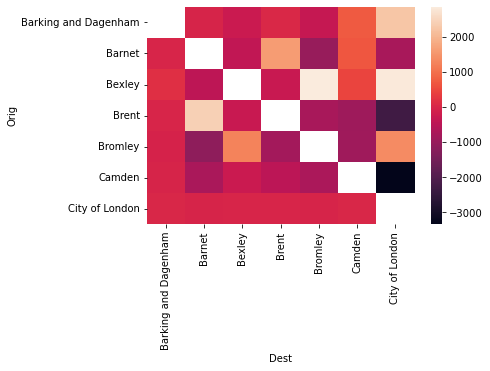

In [44]:
sns.heatmap((cdatasubmat - cdatasubmat8).iloc[:-1, :-1])

Now you have the results what do these mean. 
- Where have flows from dropped? 

Decreases in flows from Bexley to Bromley and City of London
- Where have flows increased from?

Increases in flows to the City of London from camden and Brent.
- Which flow was most affected? 

Flows to the city of London.

- Why do you think that is? 

The attraction constrained model suggests that people are attracted to certain locations and their movment is constrained by factors such as the transport infrastructure. The decreases in flows from periphery regions of London (Barking and Dagenham, Bexley, Bromley), with the simultaneous increases of flows from more central Boroughs (Camden) would suggest that the transport infrastructures are linked in some way and that the population is attracted to the central zones for jobs. 

- Is the attraction constrained model appropriate?

The attraction (destination) constrained model is most appropriate for identifying how a large input of housing stock in one area would infulence flows to other areas. As we are trying to understand what draws workers to their workplace. 

- Would jobs respond to the increase in households, or would it be the other way round?

When more people move into an area, it can create a demand for new businesses and jobs, but it can also work the other way around. When new jobs become available in a certain area, more people might move there to take those jobs. 